## Week 11 Lecture 2 - It's instrumental 

McElreath's lectures for today: https://www.youtube.com/watch?v=oMiSb8GKR0o&list=PLDcUM9US4XdMROZ57-OIRtIK0aOynbgZN&index=19

McElreath's lectures for the whole book are available here: https://github.com/rmcelreath/stat_rethinking_2022

An R/Stan repo of code is available here: https://vincentarelbundock.github.io/rethinking2/

Dustin Stansbury has some lovely PyMC Code available here: https://github.com/dustinstansbury/statistical-rethinking-2023

You are encouraged to work through both of these versions to re-enforce what we're doing in class.

In [107]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp 
import random as rd
import pdb
import pymc as pm
import arviz as az
from matplotlib import pyplot as plt
import networkx as nx
import dataframe_image as dfi


# Helper functions
def stdize(x):
    return (x-np.mean(x))/np.std(x)

def stdizeNA(x):
    xnew = x
    mask = np.isnan(x)==False
    xnew[mask] = (x[mask]-np.mean(x[mask]))/np.std(x[mask])
    return xnew

def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

def logit(p):
    return np.log(p) - np.log(1 - p)

def invlogit(p):
    return np.exp(p) / (1 + np.exp(p))


from matplotlib.patches import Ellipse
from scipy.stats import chi2


# Causal instruments

Unmeasured variables can ruin your day. It may be that you have the greatest dataset ever, with all the variables you care about collected without error. Except for that one common cause that, for one reason or another, no one bothered to think about. Unfortunately in many cases such unmeasured variables generate an unknowable level of bias that will put all your causal conclusions in doubt. It's just the way of the world.

Yet not all is lost - in some cases, if you understand the problem really well, there lies hope. Given some very specific conditions, there may be another measured variable that will save you - the instrument, a variable that bypasses the confounding backdoor and delivers causal inference on a plate.

The special conditions are only three, and are often hard to meet, but they can save the day if met. For a simple problem where Education ($E$) affects wages ($W$), we might have some unmeasured confound ($U$):

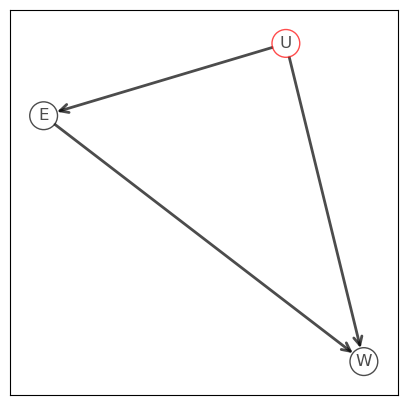

In [108]:
fig = plt.figure(figsize=(5,5))
G = nx.DiGraph(directed=True)
G.add_edges_from(
    [('U', 'W'), ('U', 'E'), ('E', 'W')], width=3)
cdict = {'U':'red', 'W':'black', 'E':'black'}
options = {
    'node_color': 'white',
    'node_size': 400,
    'width': 2,
    'arrowstyle': '->',
    'arrowsize': 15,
    "edgecolors": [cdict[i] for i in np.array(G.nodes)],
    "alpha": 0.7
}
nx.draw_networkx(G, arrows=True, **options)
plt.savefig('basicDAG.jpg',dpi=300)

If we can find some sort of an instrument, we can overcome this probelm. Here an instrument might be the quarter of the year ($Q$) that someone is born in. This quarter variable $Q$ is instrumenetal if:

1. Q is independent of U (Q⫫U)
2. Q is not-independent of E (Q$\not\!\perp\!\!\!\perp$E)
3. Q cannot influence W except through E

The first condition is obvious - U needs to not confound the instrument Q. The second is also - we need Q to represent the effect of E. The third conditon is because we need the effect of Q to be isolated to working just through E. Importantly there may be cases where this can happen by blocking other backdoor paths (and dagitty has settings for this), but for clarity here it happens because there are no other pathways from Q than through E.

For the DAG above, it might look like this

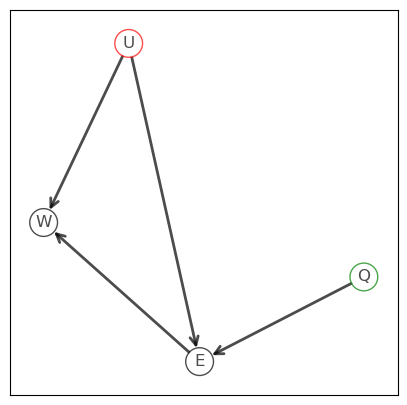

In [109]:
fig = plt.figure(figsize=(5,5))
G = nx.DiGraph(directed=True)
G.add_edges_from(
    [('U', 'W'), ('U', 'E'), ('Q', 'E'), ('E', 'W')], width=3)
cdict = {'U':'red', 'Q':'green', 'W':'black', 'E':'black'}
options = {
    'node_color': 'white',
    'node_size': 400,
    'width': 2,
    'arrowstyle': '->',
    'arrowsize': 15,
    "edgecolors": [cdict[i] for i in np.array(G.nodes)],
    "alpha": 0.7
}
nx.draw_networkx(G, arrows=True, **options)
plt.savefig('InstrumentDAG.jpg',dpi=300)

To make this all concrete, let's simulate some data for the situation above

In [110]:
# Number of cases
N = 500

# Create U
U_sim = np.random.normal(size=N)
# Create Q
Q_sim = np.random.choice([1, 2, 3, 4], size=N, replace=True)
# Create E
E_sim = np.random.normal(loc=U_sim + Q_sim)
# Create W
W_sim = np.random.normal(loc=U_sim + 0*E_sim)

# Standardize the data
dat_sim = {
    "W": sp.stats.zscore(W_sim),
    "E": sp.stats.zscore(E_sim),
    "Q": sp.stats.zscore(Q_sim)
}

So here, where the effect of $E$ is set to be zero, let's see what the consequences of U are on our inference

In [111]:
with pm.Model() as m14_4:
    # Priors
    aW = pm.Normal("aW", mu=0, sigma=0.2)  # Prior for aW
    bEW = pm.Normal("bEW", mu=0, sigma=0.5)  # Prior for bEW
    sigma = pm.Exponential("sigma", lam=1)  # Prior for sigma

    # Linear model
    mu = aW + bEW * dat_sim["E"]

    # Likelihood
    W = pm.Normal("W", mu=mu, sigma=sigma, observed=dat_sim["W"])

In [112]:
with m14_4:
    # Sampling
    trace_basic = pm.sample(chains=4, cores=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aW, bEW, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [113]:
pm.summary(trace_basic)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
aW,0.000,0.040,-0.076,0.075,0.001,0.001,5699.0,2930.0,1.0
bEW,0.383,0.042,0.308,0.461,0.001,0.000,5598.0,3063.0,1.0
sigma,0.926,0.030,0.871,0.981,0.000,0.000,5787.0,2711.0,1.0


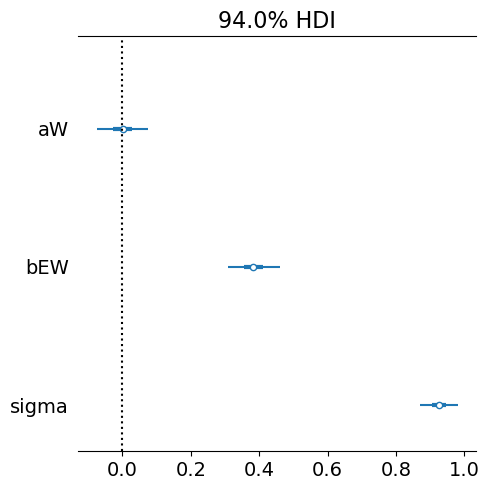

In [128]:
pm.plot_forest(trace_basic, var_names=['aW','bEW','sigma'],figsize=(5,5),combined=True)
plt.axvline(0,linestyle=":",c='black')
plt.tight_layout()
plt.savefig('basic.jpg',dpi=300);

So where we run an ingnorant analysis, where we don't have a DAG to tell us that U is an important confounder, the resutls show that E has a clear effect on W - something around 0.4 [0.3, 0.5]. Clearly we have a problem.

Now how should we apply our instrument? Simply add it to the model?

In [115]:
with pm.Model() as m14_5:
    # Priors
    aW = pm.Normal("aW", mu=0, sigma=0.2)  # Prior for aW
    bEW = pm.Normal("bEW", mu=0, sigma=0.5)  # Prior for bEW
    bQW = pm.Normal("bQW", mu=0, sigma=0.5)  # Prior for bQW
    sigma = pm.Exponential("sigma", lam=1)  # Prior for sigma

    # Linear model
    mu = aW + bEW * dat_sim["E"] + bQW * dat_sim["Q"]

    # Likelihood
    W = pm.Normal("W", mu=mu, sigma=sigma, observed=dat_sim["W"])

In [116]:
with m14_5:
    # Sampling
    trace_nutty = pm.sample(chains=4, cores=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aW, bEW, bQW, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [117]:
pm.summary(trace_nutty)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
aW,0.001,0.040,-0.075,0.073,0.001,0.001,3377.0,2899.0,1.0
bEW,0.588,0.050,0.495,0.681,0.001,0.001,3338.0,3289.0,1.0
bQW,-0.325,0.050,-0.417,-0.229,0.001,0.001,3348.0,3181.0,1.0
sigma,0.891,0.028,0.842,0.946,0.000,0.000,3968.0,2833.0,1.0


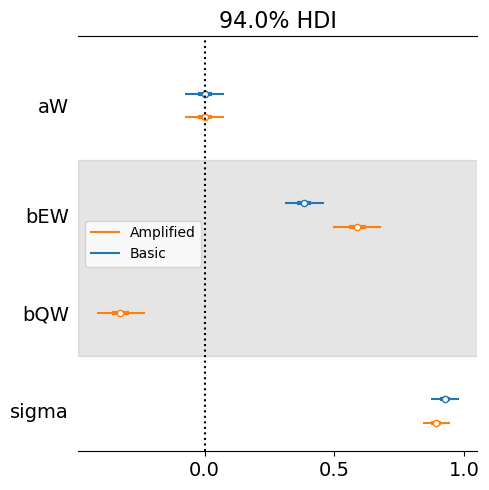

In [129]:
pm.plot_forest(
    [trace_basic,trace_nutty], 
    model_names = ['Basic','Amplified'],
    var_names=['aW','bEW','bQW','sigma'],
    figsize=(5,5),
    combined=True

)
plt.axvline(0,linestyle=":",c='black')
plt.tight_layout()
plt.savefig('nutty.jpg',dpi=300);

Ok, now things are going really nuts - the effect of E has become even larger, due to the backdoor path to Q that is negative. Clearly that's not how to introduce the instrument as it simply amplifies the bias of U. 

Inclusion of Q needs to happen in a different way - through what is known as the *generative model*. A generative model is a way of thinking about modelling whereby you create a model based on how you think the data arose in the first place. In the case where you simulate data it's easy, in that we can simply translate each step in the simulation into a node in the model, so

`W_sim = np.random.normal(loc=U_sim + 0*E_sim)`

becomes

$$
W_i \sim \text{Normal}(\mu_{w,i}, \sigma_w)
$$
$$
\mu_{w,i} = \alpha_w + \beta_{ew} E_i + U_i
$$

`E_sim = np.random.normal(loc=U_sim + Q_sim)`

becomes

$$
E_i \sim \text{Normal}(\mu_{e,i}, \sigma_e)
$$
$$
\mu_{e,i} = \alpha_e + \beta_{qe} Q_i + U_i
$$

`Q_sim = np.random.choice([1, 2, 3, 4], size=N, replace=True)`

becomes

$$
Q_i \sim \text{Categorical}([0.25, 0.25, 0.25, 0.25])
$$

and 

`U_sim = np.random.normal(size=N)`

becomes

$$
U_i \sim \text{Normal}(0, 1)
$$

With all these elements in place, we can then translate into a full statistical model that averages over $U$ and estimates instead the covariance between $W$ and $E$ - essentially dropping $U$ from both linear models and instead estimating that same effect through the correlation parameter $\rho$

$$
\begin{bmatrix}
W_i \\
E_i
\end{bmatrix}
\sim \text{MVNormal}
\left(
\begin{bmatrix}
\mu_{w,i} \\
\mu_{e,i}
\end{bmatrix},
\mathbf{S}
\right)
$$

$$
\mu_{w,i} = \alpha_w + \beta_{ew} E_i
$$
$$
\mu_{e,i} = \alpha_e + \beta_{qe} Q_i
$$

In PyMC this becomes

In [119]:
with pm.Model() as m14_6:
    # Priors for intercepts
    aW = pm.Normal("aW", mu=0, sigma=0.2)  # Intercept for W
    aE = pm.Normal("aE", mu=0, sigma=0.2)  # Intercept for E

    # Priors for slopes
    bEW = pm.Normal("bEW", mu=0, sigma=0.5)  # Slope for E in muW
    bQE = pm.Normal("bQE", mu=0, sigma=0.5)  # Slope for Q in muE

    # Linear models
    muW = aW + bEW * dat_sim["E"]
    muE = aE + bQE * dat_sim["Q"]

    # Priors for correlation matrix and standard deviations
    RhoCO = pm.LKJCholeskyCov("RhoCO", n=2, eta=2, sd_dist=pm.Exponential.dist(1))
    chol, corr, stds = RhoCO

    # Sigma
    Sigma = pm.Deterministic('Sigma', stds)

    # Rho
    Rho = pm.Deterministic('Rho', corr)

    # Multivariate normal distribution for (W, E)
    cov = pm.Deterministic("cov", chol @ chol.T)
    mu = pm.Deterministic("mu", pm.math.stack([muW, muE], axis=1))
    observed = np.stack([dat_sim["W"], dat_sim["E"]], axis=1)

    # likelihoood
    W_E = pm.MvNormal("W_E", mu=mu, chol=chol, observed=observed)

In [120]:
with m14_6:
    # Sampling
    trace_boss = pm.sample(chains=4, cores=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aW, aE, bEW, bQE, RhoCO]


/Users/aaronmacneil/mambaforge/envs/gsm-project/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


In [121]:
pm.summary(trace_boss, var_names=['aE','aW','bQE','bEW','Rho','Sigma'])

/Users/aaronmacneil/mambaforge/envs/gsm-project/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
aE,-0.000,0.035,-0.067,0.063,0.001,0.001,3967.0,3314.0,1.0
aW,0.000,0.043,-0.075,0.085,0.001,0.001,3760.0,2614.0,1.0
bQE,0.628,0.035,0.566,0.696,0.001,0.000,3791.0,3083.0,1.0
bEW,0.071,0.071,-0.066,0.199,0.001,0.001,2391.0,2573.0,1.0
"Rho[0, 0]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,NaN
"Rho[0, 1]",0.410,0.061,0.297,0.521,0.001,0.001,2279.0,2799.0,1.0
"Rho[1, 0]",0.410,0.061,0.297,0.521,0.001,0.001,2279.0,2799.0,1.0
"Rho[1, 1]",1.000,0.000,1.000,1.000,0.000,0.000,3928.0,4000.0,1.0
Sigma[0],0.980,0.039,0.904,1.048,0.001,0.001,2707.0,2909.0,1.0
Sigma[1],0.777,0.025,0.732,0.824,0.000,0.000,5407.0,3679.0,1.0


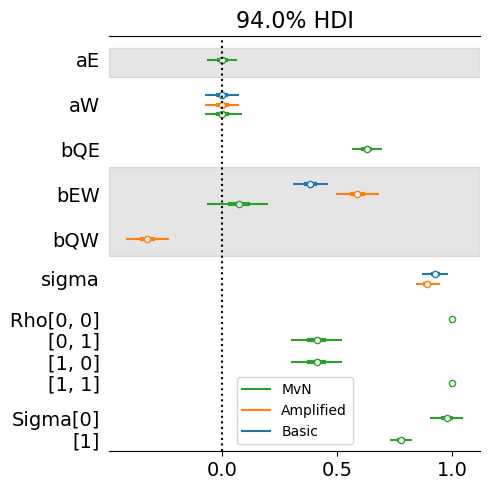

In [130]:
pm.plot_forest(
    [trace_basic,trace_nutty,trace_boss], 
    model_names = ['Basic','Amplified','MvN'],
    var_names=['aE','aW','bQE','bEW','bQW','sigma','Rho','Sigma'],
    figsize=(5,5),
    combined=True
)
plt.axvline(0,linestyle=":",c='black')
plt.tight_layout()
plt.savefig('full.jpg',dpi=300);

Now we get what we want - $E$ no longer has an effect (we set it to zero after all) and we make the correct inference. Let's try this again where we vary the parameters so that $E$ now has an effect

In [123]:
# Number of cases
N = 500

# Create U
U_sim = np.random.normal(size=N)
# Create Q
Q_sim = np.random.choice([1, 2, 3, 4], size=N, replace=True)
# Create E
E_sim = np.random.normal(loc=U_sim + Q_sim)
# Effect of E
bE_sim = -1.
# Create W
W_sim = np.random.normal(loc=U_sim + bE_sim*E_sim)

# Standardize the data
dat_sim = {
    "W": sp.stats.zscore(W_sim),
    "E": sp.stats.zscore(E_sim),
    "Q": sp.stats.zscore(Q_sim)
}

And re-running our model above

In [124]:
with pm.Model() as m14_6_2:
    # Priors for intercepts
    aW = pm.Normal("aW", mu=0, sigma=0.2)  # Intercept for W
    aE = pm.Normal("aE", mu=0, sigma=0.2)  # Intercept for E

    # Priors for slopes
    bEW = pm.Normal("bEW", mu=0, sigma=0.5)  # Slope for E in muW
    bQE = pm.Normal("bQE", mu=0, sigma=0.5)  # Slope for Q in muE

    # Linear models
    muW = aW + bEW * dat_sim["E"]
    muE = aE + bQE * dat_sim["Q"]

    # Priors for correlation matrix and standard deviations
    RhoCO = pm.LKJCholeskyCov("RhoCO", n=2, eta=2, sd_dist=pm.Exponential.dist(1))
    chol, corr, stds = RhoCO

    # Sigma
    Sigma = pm.Deterministic('Sigma', stds)

    # Rho
    Rho = pm.Deterministic('Rho', corr)

    # Multivariate normal distribution for (W, E)
    cov = pm.Deterministic("cov", chol @ chol.T)
    mu = pm.Deterministic("mu", pm.math.stack([muW, muE], axis=1))
    observed = np.stack([dat_sim["W"], dat_sim["E"]], axis=1)

    # likelihoood
    W_E = pm.MvNormal("W_E", mu=mu, chol=chol, observed=observed)

In [125]:
with m14_6_2:
    # Sampling
    trace_bossy = pm.sample(chains=4, cores=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aW, aE, bEW, bQE, RhoCO]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


In [126]:
pm.summary(trace_bossy, var_names=['aE','aW','bQE','bEW','Rho','Sigma'])

/Users/aaronmacneil/mambaforge/envs/gsm-project/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
aE,0.000,0.035,-0.068,0.063,0.001,0.001,4213.0,3290.0,1.0
aW,-0.001,0.035,-0.066,0.065,0.001,0.001,4259.0,3047.0,1.0
bQE,0.615,0.035,0.548,0.677,0.001,0.000,3454.0,2939.0,1.0
bEW,-0.930,0.058,-1.047,-0.828,0.001,0.001,2143.0,1992.0,1.0
"Rho[0, 0]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,NaN
"Rho[0, 1]",0.434,0.059,0.318,0.541,0.001,0.001,2080.0,2251.0,1.0
"Rho[1, 0]",0.434,0.059,0.318,0.541,0.001,0.001,2080.0,2251.0,1.0
"Rho[1, 1]",1.000,0.000,1.000,1.000,0.000,0.000,3966.0,3463.0,1.0
Sigma[0],0.805,0.033,0.746,0.869,0.001,0.000,2501.0,2693.0,1.0
Sigma[1],0.791,0.025,0.745,0.836,0.000,0.000,5349.0,3675.0,1.0


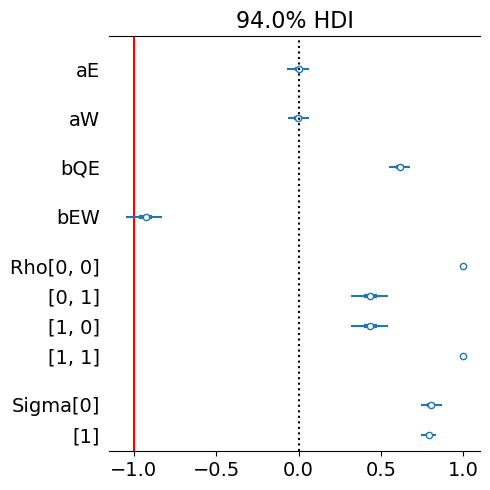

In [131]:
pm.plot_forest(trace_bossy, var_names=['aE','aW','bQE','bEW','Rho','Sigma'],figsize=(5,5),combined=True)
plt.axvline(0,linestyle=":",c='black')
plt.axvline(bE_sim,c='red',zorder=0)
plt.tight_layout()
plt.savefig('covar.jpg',dpi=300);

Now we're cooking - we get back the $-1$ish effect of $E$ on $W$. 